# New York City Taxi Trip Duration
Regression: Tabular data

### EDA + Baseline Model
(참고 커널) https://www.kaggle.com/aiswaryaramachandran/eda-baseline-model-0-40-rmse 

### Problem and Data Explanation
대회목적 : 뉴욕에서의 택시 여행 기간을 예측하는 모델을 만드는것

### Data fields
* id - a unique identifier for each trip
* vendor_id - a code indicating the provider associated with the trip record
* pickup_datetime - date and time when the meter was engaged
* dropoff_datetime - date and time when the meter was disengaged
* passenger_count - the number of passengers in the vehicle (driver entered value)
* pickup_longitude - the longitude where the meter was engaged
* pickup_latitude - the latitude where the meter was engaged
* dropoff_longitude - the longitude where the meter was disengaged
* dropoff_latitude - the latitude where the meter was disengaged
* store_and_fwd_flag - This flag indicates whether the trip record was held in vehicle memory before sending to the vendor because the vehicle did not have a connection to the server - Y=store and forward; N=not a store and forward trip
* trip_duration - duration of the trip in seconds


### what I learned
* map함수, apply함수
    * Pandas에서 제공하지 않는 기능, 내가 만든 커스텀함수를 Dataframe에적용할 때
    * map함수 : 반드시 Series타입에서만 사용 가능
    * apply함수 :커스텀함수를 사용하기 위해 Dataframe에서 복수 개의 컬럼이 필요할 때
* Haversine Distance (위도,경도로 거리구하기, 단위:km)
* follium, 지리 데이터 시각화 라이브러리
* countplot 에서 x축 순서 고정
    * sns.countplot(train['pickup_day_of_week'],order=['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday', 'Sunday'])
    * 월,화,수,목,금,토,일 순으로

In [32]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import warnings
from datetime import datetime
import calendar
from math import sin, cos, sqrt, atan2, radians
from folium import FeatureGroup, LayerControl, Map, Marker
from folium.plugins import HeatMap
import matplotlib.dates as mdates
import matplotlib as mpl
from datetime import timedelta
import datetime as dt
warnings.filterwarnings('ignore')
pd.set_option('display.max_colwidth', -1)
plt.style.use('fivethirtyeight')
import folium

from sklearn.cluster import KMeans
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import Imputer
from sklearn import linear_model
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor
import pickle

In [2]:
train=pd.read_csv("./train.csv")
test=pd.read_csv("./test.csv")
test.shape

(625134, 9)

In [3]:
train['pickup_datetime'].dtype

dtype('O')

###  Convert to appropriate datatype
pickup datetime과 dropoff datetime을 date-time object로 변경

In [4]:
train['pickup_datetime']=pd.to_datetime(train['pickup_datetime'], format='%Y-%m-%d %H:%M:%S')
train['dropoff_datetime']=pd.to_datetime(train['dropoff_datetime'], format='%Y-%m-%d %H:%M:%S')
train.head()

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982155,40.767937,-73.964630,40.765602,N,455
1,id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980415,40.738564,-73.999481,40.731152,N,663
2,id3858529,2,2016-01-19 11:35:24,2016-01-19 12:10:48,1,-73.979027,40.763939,-74.005333,40.710087,N,2124
3,id3504673,2,2016-04-06 19:32:31,2016-04-06 19:39:40,1,-74.010040,40.719971,-74.012268,40.706718,N,429
4,id2181028,2,2016-03-26 13:30:55,2016-03-26 13:38:10,1,-73.973053,40.793209,-73.972923,40.782520,N,435


In [5]:
train['pickup_datetime'].dtype

dtype('<M8[ns]')

### Are there any missing values in the data?

In [6]:
train[pd.isnull(train)].sum()

id                    0.0
vendor_id             0.0
pickup_datetime       0.0
dropoff_datetime      0.0
passenger_count       0.0
pickup_longitude      0.0
pickup_latitude       0.0
dropoff_longitude     0.0
dropoff_latitude      0.0
store_and_fwd_flag    0.0
trip_duration         0.0
dtype: float64

missing values는 없는것으로 보임

### What is the time period of the dataset?

In [7]:
print("Min pickup time:", min(train['pickup_datetime']))
print("Max pickup time:", max(train['pickup_datetime']))

Min pickup time: 2016-01-01 00:00:17
Max pickup time: 2016-06-30 23:59:39


데이터는 2016 1월부터 6월까지 총 6개월치인것을 확인

### create new day,month, hour info from Pickup time

In [8]:
train['pickup_date'] = train['pickup_datetime'].dt.date
train['pickup_day']=train['pickup_datetime'].apply(lambda x:x.day)
train['pickup_hour']=train['pickup_datetime'].apply(lambda x:x.hour)
train['pickup_day_of_week']=train['pickup_datetime'].apply(lambda x:calendar.day_name[x.weekday()])

train['dropoff_date']=train['dropoff_datetime'].dt.date
train['dropoff_day']=train['dropoff_datetime'].apply(lambda x:x.day)
train['dropoff_hour']=train['dropoff_datetime'].apply(lambda x:x.hour)
train['dropoff_day_of_week']=train['dropoff_datetime'].apply(lambda x:calendar.day_name[x.weekday()] )

### Round lat lng to 3 decimal places

In [9]:
train['pickup_latitude_round3']=train['pickup_latitude'].apply(lambda x:round(x,3))
train['pickup_longitude_round3']=train['pickup_longitude'].apply(lambda x: round(x,3))
train['dropoff_latitude_round3']=train['dropoff_latitude'].apply(lambda x:round(x,3))
train['dropoff_longitude_round3']=train['dropoff_longitude'].apply(lambda x:round(x,3))
train.head()

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,...,pickup_hour,pickup_day_of_week,dropoff_date,dropoff_day,dropoff_hour,dropoff_day_of_week,pickup_latitude_round3,pickup_longitude_round3,dropoff_latitude_round3,dropoff_longitude_round3
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982155,40.767937,-73.964630,40.765602,N,...,17,Monday,2016-03-14,14,17,Monday,40.768,-73.982,40.766,-73.965
1,id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980415,40.738564,-73.999481,40.731152,N,...,0,Sunday,2016-06-12,12,0,Sunday,40.739,-73.980,40.731,-73.999
2,id3858529,2,2016-01-19 11:35:24,2016-01-19 12:10:48,1,-73.979027,40.763939,-74.005333,40.710087,N,...,11,Tuesday,2016-01-19,19,12,Tuesday,40.764,-73.979,40.710,-74.005
3,id3504673,2,2016-04-06 19:32:31,2016-04-06 19:39:40,1,-74.010040,40.719971,-74.012268,40.706718,N,...,19,Wednesday,2016-04-06,6,19,Wednesday,40.720,-74.010,40.707,-74.012
4,id2181028,2,2016-03-26 13:30:55,2016-03-26 13:38:10,1,-73.973053,40.793209,-73.972923,40.782520,N,...,13,Saturday,2016-03-26,26,13,Saturday,40.793,-73.973,40.783,-73.973


### Based on Latitude and Longitude get the distance of the trip in km
This uses Haversine Distance

In [10]:
# 거리계산
def calculateDistance(row):
    R=6373.0
    # radian으로 단위 변경 
    pickup_lat=radians(row['pickup_latitude'])
    pickup_lon=radians(row['pickup_longitude'])
    dropoff_lat=radians(row['dropoff_latitude'])
    dropoff_lon=radians(row['dropoff_longitude'])
    dlon = dropoff_lon - pickup_lon
    dlat = dropoff_lat - pickup_lat
    a = sin(dlat / 2)**2 + cos(pickup_lat) * cos(dropoff_lat) * sin(dlon / 2)**2
    c = 2 * atan2(sqrt(a), sqrt(1 - a))
    distance = R * c
    return distance
    

In [11]:
train['trip_distance']=train.apply(lambda row:calculateDistance(row),axis=1)
train.head()

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,...,pickup_day_of_week,dropoff_date,dropoff_day,dropoff_hour,dropoff_day_of_week,pickup_latitude_round3,pickup_longitude_round3,dropoff_latitude_round3,dropoff_longitude_round3,trip_distance
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982155,40.767937,-73.964630,40.765602,N,...,Monday,2016-03-14,14,17,Monday,40.768,-73.982,40.766,-73.965,1.498991
1,id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980415,40.738564,-73.999481,40.731152,N,...,Sunday,2016-06-12,12,0,Sunday,40.739,-73.980,40.731,-73.999,1.806074
2,id3858529,2,2016-01-19 11:35:24,2016-01-19 12:10:48,1,-73.979027,40.763939,-74.005333,40.710087,N,...,Tuesday,2016-01-19,19,12,Tuesday,40.764,-73.979,40.710,-74.005,6.387103
3,id3504673,2,2016-04-06 19:32:31,2016-04-06 19:39:40,1,-74.010040,40.719971,-74.012268,40.706718,N,...,Wednesday,2016-04-06,6,19,Wednesday,40.720,-74.010,40.707,-74.012,1.485965
4,id2181028,2,2016-03-26 13:30:55,2016-03-26 13:38:10,1,-73.973053,40.793209,-73.972923,40.782520,N,...,Saturday,2016-03-26,26,13,Saturday,40.793,-73.973,40.783,-73.973,1.188962


In [12]:
# 1시간당 duration
train['trip_duration_in_hour']=train['trip_duration'].apply(lambda x: x/3600)
train.head()

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,...,dropoff_date,dropoff_day,dropoff_hour,dropoff_day_of_week,pickup_latitude_round3,pickup_longitude_round3,dropoff_latitude_round3,dropoff_longitude_round3,trip_distance,trip_duration_in_hour
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982155,40.767937,-73.964630,40.765602,N,...,2016-03-14,14,17,Monday,40.768,-73.982,40.766,-73.965,1.498991,0.126389
1,id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980415,40.738564,-73.999481,40.731152,N,...,2016-06-12,12,0,Sunday,40.739,-73.980,40.731,-73.999,1.806074,0.184167
2,id3858529,2,2016-01-19 11:35:24,2016-01-19 12:10:48,1,-73.979027,40.763939,-74.005333,40.710087,N,...,2016-01-19,19,12,Tuesday,40.764,-73.979,40.710,-74.005,6.387103,0.590000
3,id3504673,2,2016-04-06 19:32:31,2016-04-06 19:39:40,1,-74.010040,40.719971,-74.012268,40.706718,N,...,2016-04-06,6,19,Wednesday,40.720,-74.010,40.707,-74.012,1.485965,0.119167
4,id2181028,2,2016-03-26 13:30:55,2016-03-26 13:38:10,1,-73.973053,40.793209,-73.972923,40.782520,N,...,2016-03-26,26,13,Saturday,40.793,-73.973,40.783,-73.973,1.188962,0.120833


### Exploratory Analysis

Text(0.5, 0, 'Trip Duration (in hour)')

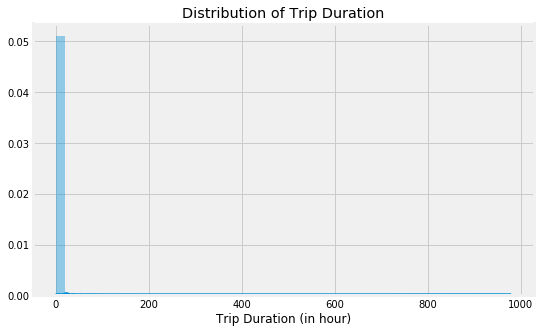

In [13]:
plt.figure(figsize=(8,5))
sns.distplot(train['trip_duration_in_hour']).set_title('Distribution of Trip Duration')
plt.xlabel('Trip Duration (in hour)')

trip duration이 24시간 이상인 경우가 있다. 이는 이상치

In [14]:
outlier_trip_duration=train.loc[train['trip_duration_in_hour']>24]
outlier_trip_duration

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,...,dropoff_date,dropoff_day,dropoff_hour,dropoff_day_of_week,pickup_latitude_round3,pickup_longitude_round3,dropoff_latitude_round3,dropoff_longitude_round3,trip_distance,trip_duration_in_hour
355003,id1864733,1,2016-01-05 00:19:42,2016-01-27 11:08:38,1,-73.789650,40.643559,-73.956810,40.773087,N,...,2016-01-27,27,11,Wednesday,40.644,-73.790,40.773,-73.957,20.154989,538.815556
680594,id0369307,1,2016-02-13 22:38:00,2016-03-08 15:57:38,2,-73.921677,40.735252,-73.984749,40.759979,N,...,2016-03-08,8,15,Tuesday,40.735,-73.922,40.760,-73.985,5.984365,569.327222
924150,id1325766,1,2016-01-05 06:14:15,2016-01-31 01:01:07,1,-73.983788,40.742325,-73.985489,40.727676,N,...,2016-01-31,31,1,Sunday,40.742,-73.984,40.728,-73.985,1.635641,618.781111
978383,id0053347,1,2016-02-13 22:46:52,2016-03-25 18:18:14,1,-73.783905,40.648632,-73.978271,40.750202,N,...,2016-03-25,25,18,Friday,40.649,-73.784,40.750,-73.978,19.906909,979.522778


distace travelled가 굉장히 낮다. 이것들은 outlier임.<br>
이 trip이 어디서 시작했고 끝났는지에 대한 특정 location이 있나? <br>
Trip duration은 skewed하므로, log변환을 하겠다. <br>

우리는 이것또한 test data의 일부이므로 제거하지 않겠다.

Text(0.5, 1.0, 'Distribution of trip duration (sec) in Log Scale')

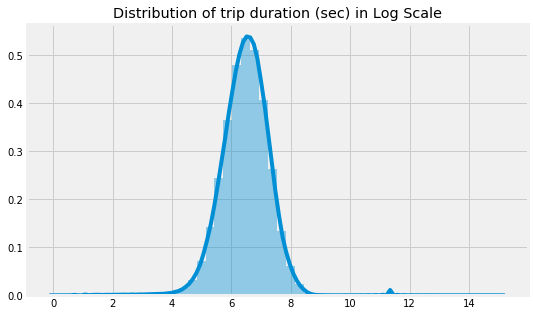

In [15]:
plt.figure(figsize=(8,5))
sns.distplot(np.log(train['trip_duration'].values)).set_title('Distribution of Trip Duration')
plt.title("Distribution of trip duration (sec) in Log Scale")

trip duration을 log변환시킨 결과는 정규분포 형태이다.<br>
대부분의 trip은 54 sec (exp(4)) 과 2980 sec (exp(8)) 사이에 있다. <br>
이는 대부분의 trip이 1시간 이내라는 것을 의미한다. 하지만, trip이 1분보다도 적은 경우도 있기 때문에 자세하게 살펴볼 필요가 있다.  <br>
trip이 100시간 지속된다는것은 taxi rides로서 이상하다.

### Heatmap of common locations from where pickup and dropoff occurs

In [16]:
# pickup 위도,경도가 같은 id를 카운트
pickup=train.groupby(['pickup_latitude_round3','pickup_longitude_round3'])['id'].count().reset_index().rename(columns={'id':'Num_Trips'})

In [17]:
pickup_map = folium.Map(location = [40.730610,-73.935242],zoom_start = 10,)
#print(pickup.shape)
### For each pickup point add a circlemarker
'''
for index, row in pickup.iterrows():
    
    folium.CircleMarker([row['pickup_latitude_round3'], row['pickup_longitude_round3']],
                        radius=3,
                        
                        fill_color="#3db7e4", 
                        fill_opacity=0.9
                       ).add_to(pickup_map)
    count=count + 1


'''

hm_wide = HeatMap( list(zip(pickup.pickup_latitude_round3.values, pickup.pickup_longitude_round3.values, pickup.Num_Trips.values)),
                     min_opacity=0.2,
                     radius=5, blur=15,
                     max_zoom=1 
                 )
pickup_map.add_child(hm_wide)

pickup_map

TypeError: Object of type int64 is not JSON serializable

(-74.03, -73.75)

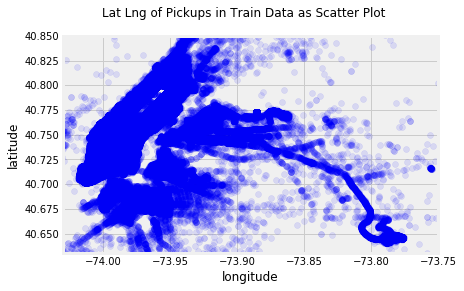

In [18]:
city_long_border = (-74.03, -73.75)
city_lat_border = (40.63, 40.85)
fig, ax = plt.subplots(ncols=1, sharex=True, sharey=True)
ax.scatter(train['pickup_longitude'], train['pickup_latitude'],
              color='blue', label='train', alpha=0.1)

fig.suptitle('Lat Lng of Pickups in Train Data as Scatter Plot')

ax.set_ylabel('latitude')
ax.set_xlabel('longitude')
plt.ylim(city_lat_border)
plt.xlim(city_long_border)

이 그래프는 JFK근처에 pickup이 많다는 것을 보여줌.

In [19]:
drop=train.groupby(['dropoff_latitude_round3','dropoff_longitude_round3'])['id'].count().reset_index().rename(columns={'id':'Num_Trips'})

In [20]:
drop_map = folium.Map(location = [40.730610,-73.935242],zoom_start = 10,)
hm_wide = HeatMap( list(zip(drop.dropoff_latitude_round3.values, drop.dropoff_longitude_round3.values, drop.Num_Trips.values)),
                     min_opacity=0.2,
                     radius=5, blur=15,
                     max_zoom=1 
                 )
drop_map.add_child(hm_wide)
drop_map

TypeError: Object of type int64 is not JSON serializable

In [21]:
pickup=train.groupby(['pickup_latitude_round3','pickup_longitude_round3'])['trip_duration'].mean().reset_index().rename(columns={'trip_duration':'Avg_Trip_duration'})

In [22]:
pickup_map = folium.Map(location = [40.730610,-73.935242],zoom_start = 10,)


hm_wide = HeatMap( list(zip(pickup.pickup_latitude_round3.values, pickup.pickup_longitude_round3.values, pickup.Avg_Trip_duration.values)),
                     min_opacity=0.2,
                     radius=7, blur=15,
                     max_zoom=1 
                 )
pickup_map.add_child(hm_wide)
pickup_map

trip이 JFK로부터 온경우, 평균 trip duration이 더 높다. <br>
zoom in 해보면, Manhattan이후에 JFK로부터 pickup이 trip duration이 더 높은 경향이 있다. 

### Which hours are pickup and dropoff higher?
어느 시간대에 pickup과 dropoff가 높은지 확인

Text(0.5, 1.0, 'Pickup Hours Distribution')

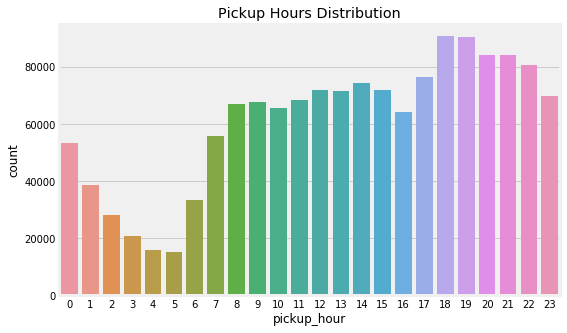

In [23]:
plt.figure(figsize=(8,5))
sns.countplot(x=train['pickup_hour']).set_title("Pickup Hours Distribution")

이른 아침에는 pickup이 훨씬 낮다. 오후6시에서 8시 사이가 가장 높다.

Text(0.5, 1.0, 'Dropoff Hours Distribution')

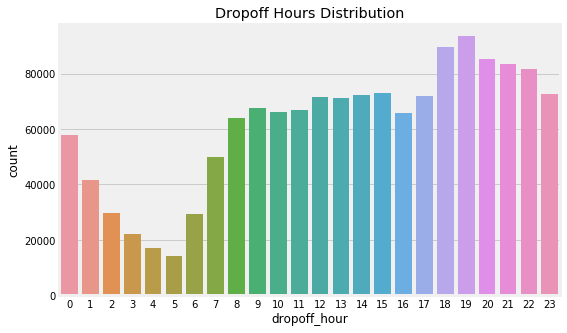

In [24]:
plt.figure(figsize=(8,5))
sns.countplot(x=train['dropoff_hour']).set_title("Dropoff Hours Distribution")

dropoff 의 분포도 pickup과 유사하다.

### Pickups over the entire time period

Text(0.5, 1.0, 'Distribution of Pickups over time')

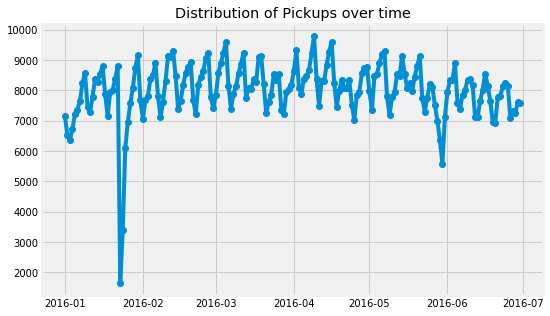

In [25]:
plt.figure(figsize=(8,5))
plt.plot(train.groupby('pickup_date').count()[['id']], 'o-', label='train')
plt.title("Distribution of Pickups over time")

2016 1월말에 pickup이 뚝 떨어진 부분이 보임.

### What is the distribution of Trip distance

Text(0.5, 0, 'Trip Distance(log)')

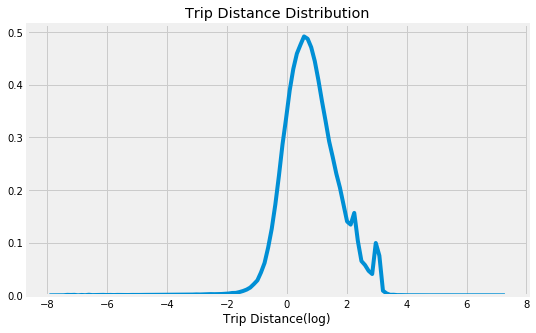

In [26]:
plt.figure(figsize=(8,5))
sns.kdeplot(np.log(train['trip_distance'].values)).set_title("Trip Distance Distribution")
plt.xlabel('Trip Distance(log)')

### Trip Duration vs Trip Distance

Text(0, 0.5, 'Trip Duration (log scale)')

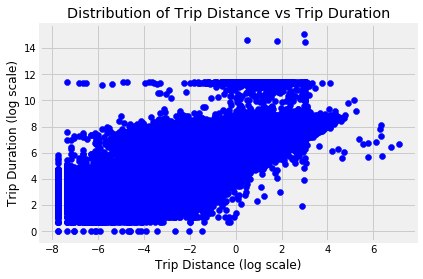

In [27]:
plt.scatter(np.log(train['trip_distance'].values), np.log(train['trip_duration'].values),
              color='blue', label='train')
plt.title("Distribution of Trip Distance vs Trip Duration")
plt.xlabel("Trip Distance (log scale)")
plt.ylabel("Trip Duration (log scale)")

### Is the trip duration higher at different hours?
trip 시간이 시간대별로 다른지확인

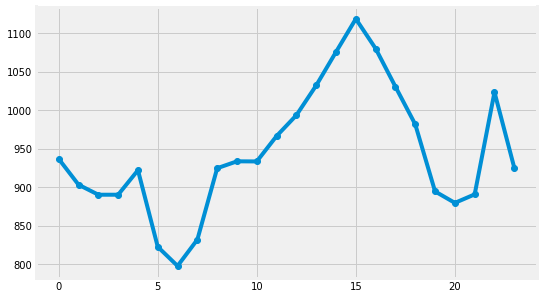

In [28]:
avg_duration_hour=train.groupby(['pickup_hour'])['trip_duration'].mean().reset_index().rename(columns={'trip_duration':'avg_trip_duration'})
plt.figure(figsize=(8,5))
plt.plot(train.groupby(['pickup_hour'])['trip_duration'].mean(),'o-')

trip duraton이 10시와 15시 사이에 증가하는것으로 보임.

### Distribution of Pickups across Days
요일별로 pickup 분포

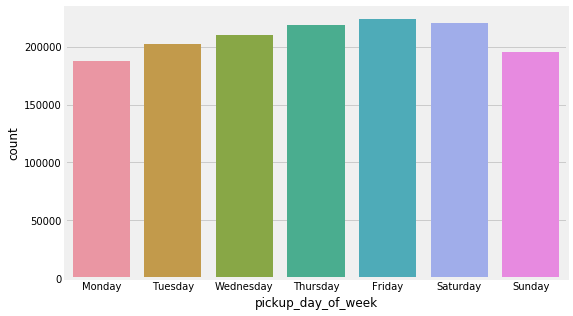

In [29]:
plt.figure(figsize=(8,5))
sns.countplot(train['pickup_day_of_week'],order=['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday', 'Sunday'])

월요일에 pickup의 수가 가장 낮고, 화요일에서 금요일로 갈수록 pickup수 증가

### Avg Trip Duration over Days of week
요일별 평균 trip duration

In [30]:
avg_duration_day=train.groupby(['pickup_day_of_week'])['trip_duration'].mean().reset_index().rename(columns={'trip_duration':'avg_trip_duration'})

Text(0.5, 1.0, 'Avg Trip Duration vs Pickup Days of Week')

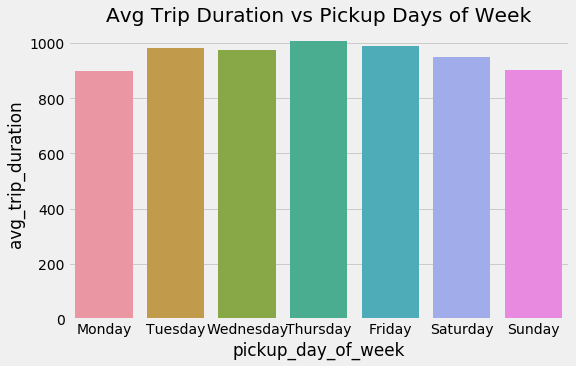

In [33]:
plt.figure(figsize=(8,5))
sns.barplot(x='pickup_day_of_week',y='avg_trip_duration',data=avg_duration_day,order=['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday', 'Sunday']).set_title("Avg Trip Duration vs Pickup Days of Week")

목요일이 평균 trip duration이 가장 높다.

### Create a caluclated field Bearing
Bearing measures the direction of travel The formula is: <br>
θ = atan2( sin Δλ ⋅ cos φ2 , cos φ1 ⋅ sin φ2 − sin φ1 ⋅ cos φ2 ⋅ cos Δλ ) <br>
λ is the longitude

In [34]:
def calculateBearing(lat1,lng1,lat2,lng2):
    R = 6371 
    lng_delta_rad = np.radians(lng2 - lng1)
    lat1, lng1, lat2, lng2 = map(np.radians, (lat1, lng1, lat2, lng2))
    y = np.sin(lng_delta_rad) * np.cos(lat2)
    x = np.cos(lat1) * np.sin(lat2) - np.sin(lat1) * np.cos(lat2) * np.cos(lng_delta_rad)
    return np.degrees(np.arctan2(y, x))

In [35]:
train['bearing']=train.apply(lambda row: calculateBearing(row['pickup_latitude_round3'],row['pickup_longitude_round3'],row['dropoff_latitude_round3'],row['dropoff_longitude_round3']),axis=1)

In [ ]:
# bearing값을 공식에따라 계산할 함수를 만들고, lambda함수를 사용해서 데이터프레임의 각 행별로 계산값 도출

----------
#### (study) 새로 생성한 함수를 row별로 연산하기 위한 lambda함수 활용

In [108]:
# 두 값을 더하는 함수 plus_values 생성
def plus_values(x,y):
    return x+y

# 샘플 데이터 만들기
a =pd.DataFrame([1,2,3],[10,20,30]).reset_index().rename(columns={0:'val1','index':'val2'})
a['val3']=a.apply(lambda x: plus_values(x['val2'], x['val1']),axis=1 )
a

,val2,val1,val3
0,10,1,11
1,20,2,22
2,30,3,33


---------
### Distribution of Bearing

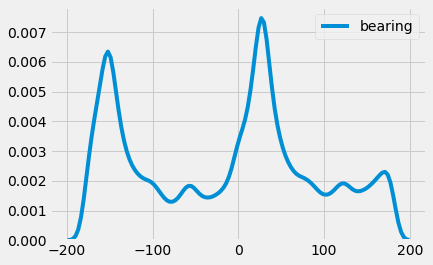

In [109]:
sns.kdeplot(train['bearing'])

### Bearing vs Trip Duration

Text(0, 0.5, 'Trip Duration (log scale)')

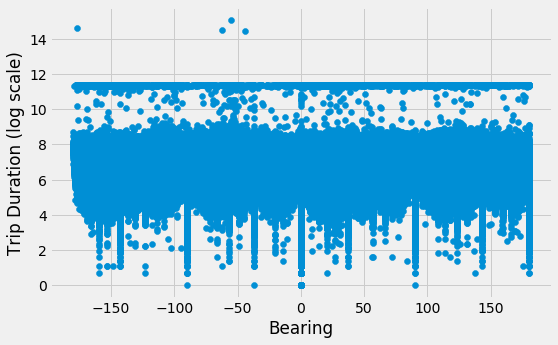

In [114]:
plt.figure(figsize=(8,5))
plt.scatter(train['bearing'].values, y=np.log(train['trip_duration'].values))
plt.xlabel("Bearing")
plt.ylabel("Trip Duration (log scale)")

bearing -50degree에 outlier들이 밀집되어있음

### Distribution of Store and FWD Flag

In [115]:
train['store_and_fwd_flag'].value_counts()

N    1450599
Y    8045   
Name: store_and_fwd_flag, dtype: int64

Text(0, 0.5, 'Density')

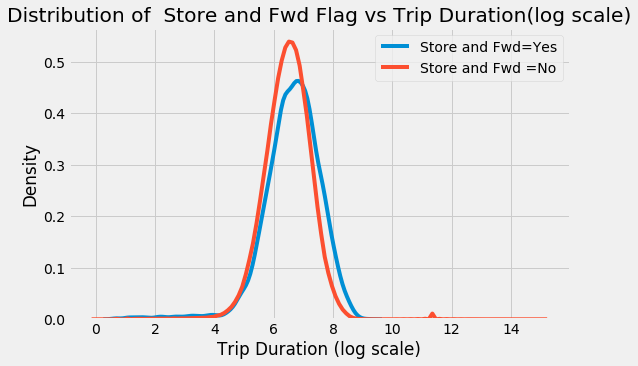

In [120]:
plt.figure(figsize=(8,5))
sns.kdeplot(np.log(train.loc[train['store_and_fwd_flag']=='Y','trip_duration'].values),label='Store and Fwd=Yes')
sns.kdeplot(np.log(train.loc[train['store_and_fwd_flag']=='N','trip_duration'].values),label= 'Store and Fwd =No')
plt.title("Distribution of  Store and Fwd Flag vs Trip Duration(log scale)")
plt.xlabel('Trip Duration (log scale)')
plt.ylabel('Density')

### Group Locations into cluster